In [7]:
# Instalação de pacotes necessários

%pip install opencv-python==4.12.0
%pip install numpy==2.2.6
%pip install matplotlib==3.10.3

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.12.0 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86, 4.12.0.88)
ERROR: No matching distribution found for opencv-python==4.12.0


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Importação de bibliotecas e verificação de versões

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(cv2.__version__)
print(np.__version__)
print(matplotlib.__version__)

4.12.0
2.2.6
3.10.3


In [9]:
def calculate_tomato_fcas(base_path: str, img_name: str, show_results: bool, plot_results: bool, print_results: bool, save_show_results = False) -> []:

    # 1. Carregar e converter a imagem
    image = cv2.imread(f'{base_path}{img_name}')
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Parâmetros para definir os limites dinâmicos
    lower_saturation_value = 100  # Valor mínimo de saturação para considerar a região como tomate
    lower_value_value = 100  # Valor mínimo de brilho para considerar a região como tomate
    hue_std_dev = 3  # Desvio padrão para definir os limites dinâmicos

    # 2. Calcular máscara inicial por saturação (onde o fundo branco ou cinza tem baixa saturação)
    sat = image_hsv[:,:,1]
    _, sat_mask = cv2.threshold(sat, lower_saturation_value, 255, cv2.THRESH_BINARY)

    # 3. Aplicar máscara na imagem HSV para calcular Hue e Saturation apenas da região provável do tomate
    masked_hsv = cv2.bitwise_and(image_hsv, image_hsv, mask=sat_mask)

    hue = masked_hsv[:,:,0][sat_mask>0]
    sat_values = masked_hsv[:,:,1][sat_mask>0]

    # 4. Calcular estatísticas
    hue_mean = np.mean(hue)
    hue_std = np.std(hue)

    sat_mean = np.mean(sat_values)
    sat_std = np.std(sat_values)

    # 5. Definir thresholds dinâmicos
    lower_hue = int(max(0, hue_mean - hue_std_dev * hue_std))
    upper_hue = int(min(179, hue_mean + hue_std_dev * hue_std))

    lower_sat = int(max(0, sat_mean - hue_std_dev * sat_std))
    upper_sat = int(min(255, sat_mean + hue_std_dev * sat_std))

    # 6. Criar máscara final com base nesses limites
    lower_bound = np.array([lower_hue, lower_sat, lower_value_value])
    upper_bound = np.array([upper_hue, upper_sat, 255])

    final_mask = cv2.inRange(image_hsv, lower_bound, upper_bound)

    # 7. Aplicar máscara na imagem original
    result = cv2.bitwise_and(image_rgb, image_rgb, mask=final_mask)

    # 8. Limpeza da máscara com morfologia
    kernel = np.ones((7,7), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)

    # 9. Encontrar contornos
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 10. Criar nova máscara preenchida (refill)
    refilled_mask = np.zeros_like(final_mask)
    cv2.drawContours(refilled_mask, contours, -1, 255, thickness=cv2.FILLED)

    # 11. Aplicar a máscara preenchida na imagem original
    final_result = cv2.bitwise_and(image_rgb, image_rgb, mask=refilled_mask)

    # 10. Aplicar transformada de distância
    dist_transform = cv2.distanceTransform(refilled_mask, cv2.DIST_L2, 5)
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(dist_transform)

    # 12. Determinar o círculo inscrito
    circle_center = maxLoc               # Centro do maior círculo
    circle_radius = int(maxVal)          # Raio do maior círculo

    # 13. Desenhar o círculo na imagem original
    output = image_rgb.copy()
    cv2.circle(output, circle_center, circle_radius, (0, 255, 0), 2)

    # 14. Calcular os raios das 5 regiões com áreas iguais
    radii = [int(np.sqrt(i/5) * circle_radius) for i in range(1, 6)]

    # 15. Desenhar os 5 círculos concêntricos
    output_circles = image_rgb.copy()
    for r in radii:
        cv2.circle(output_circles, circle_center, r, (0, 255, 0), 2)

    mean_colors_rgb = []
    mean_colors_hsv = []

    # 16. Extrair médias de cor de cada FCA
    for i in range(5):
        # Criar máscara do círculo externo
        mask_outer = np.zeros_like(refilled_mask)
        cv2.circle(mask_outer, circle_center, radii[i], 255, thickness=cv2.FILLED)
        
        # Criar máscara do círculo interno (anterior)
        if i == 0:
            mask_inner = np.zeros_like(refilled_mask)
        else:
            mask_inner = np.zeros_like(refilled_mask)
            cv2.circle(mask_inner, circle_center, radii[i-1], 255, thickness=cv2.FILLED)
        
        # Máscara do anel atual: externo - interno
        ring_mask = cv2.subtract(mask_outer, mask_inner)
        
        # Limitar o anel apenas à área do tomate (intersecção com refilled_mask)
        ring_mask = cv2.bitwise_and(ring_mask, refilled_mask)

        # Calcular média RGB
        mean_rgb = cv2.mean(image_rgb, mask=ring_mask)[:3]  # Ignora alpha
        mean_colors_rgb.append(mean_rgb)
        
        # Calcular média HSV
        mean_hsv = cv2.mean(image_hsv, mask=ring_mask)[:3]
        mean_colors_hsv.append(mean_hsv)

    if(print_results):
        print("Médias de cor por anel (RGB):")
        for i, rgb in enumerate(mean_colors_rgb):
            print(f"FCA {i+1}: R={rgb[0]:.2f}, G={rgb[1]:.2f}, B={rgb[2]:.2f}")

        print("\nMédias de cor por anel (HSV):")
        for i, hsv in enumerate(mean_colors_hsv):
            print(f"FCA {i+1}: H={hsv[0]:.2f}, S={hsv[1]:.2f}, V={hsv[2]:.2f}")

    if(show_results or save_show_results):
        plt.figure(figsize=(15, 10))

        plt.subplot(1, 4, 1)
        plt.imshow(image_rgb)
        plt.title("Imagem Original RGB")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(refilled_mask, cmap='gray')
        plt.title("Máscara Final")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(output)
        plt.title("Círculo Inscrito no Tomate")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(output_circles)
        plt.title("Áreas de Feature Color Extraction (FCA) no Tomate")
        plt.axis('off')

        plt.tight_layout()

        if (save_show_results):
            plt.savefig(f'./results/result_{img_name}.png', dpi=300, bbox_inches='tight')
            plt.close()

        if (show_results):
            plt.show()

    if(plot_results):
        rings = np.arange(1, 6)

        # Separação de cada componente RGB e HSV
        R = [rgb[0] for rgb in mean_colors_rgb]
        G = [rgb[1] for rgb in mean_colors_rgb]
        B = [rgb[2] for rgb in mean_colors_rgb]

        H = [hsv[0] for hsv in mean_colors_hsv]
        S = [hsv[1] for hsv in mean_colors_hsv]
        V = [hsv[2] for hsv in mean_colors_hsv]

        plt.figure(figsize=(12,5))

        # Plot RGB
        plt.subplot(1, 2, 1)
        plt.plot(rings, R, 'r-o', label='Red (R)')
        plt.plot(rings, G, 'g-o', label='Green (G)')
        plt.plot(rings, B, 'b-o', label='Blue (B)')
        plt.title('Média de RGB por Anel')
        plt.xlabel('Anel')
        plt.ylabel('Valor (0-255)')
        plt.xticks([1, 2, 3, 4, 5])
        plt.legend()
        plt.grid(True)

        # Plot HSV
        plt.subplot(1, 2, 2)
        plt.plot(rings, H, 'm-o', label='Hue (H)')
        plt.plot(rings, S, 'c-o', label='Saturation (S)')
        plt.plot(rings, V, 'y-o', label='Value (V)')
        plt.title('Média de HSV por Anel')
        plt.xlabel('Anel')
        plt.ylabel('Valor')
        plt.xticks([1, 2, 3, 4, 5])
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Criar uma imagem em branco para mostrar os anéis coloridos
        height, width = image_rgb.shape[:2]
        visual = np.zeros((height, width, 3), dtype=np.uint8)

        for i in range(5):
            # Máscara do anel
            mask_outer = np.zeros((height, width), dtype=np.uint8)
            cv2.circle(mask_outer, circle_center, radii[i], 255, thickness=cv2.FILLED)
            
            if i == 0:
                mask_inner = np.zeros((height, width), dtype=np.uint8)
            else:
                mask_inner = np.zeros((height, width), dtype=np.uint8)
                cv2.circle(mask_inner, circle_center, radii[i-1], 255, thickness=cv2.FILLED)
            
            ring_mask = cv2.subtract(mask_outer, mask_inner)
            ring_mask = cv2.bitwise_and(ring_mask, refilled_mask)

            # Pintar o anel com a cor média RGB
            color = tuple([int(c) for c in mean_colors_rgb[i]])
            visual[ring_mask > 0] = color

        # Mostrar a visualização dos anéis coloridos
        plt.figure(figsize=(6,6))
        plt.imshow(visual)
        plt.title("Anéis Pintados com as Cores Médias (RGB)")
        plt.axis('off')
        plt.show()


    return [mean_colors_rgb, mean_colors_hsv]

Médias de cor por anel (RGB):
FCA 1: R=224.95, G=224.76, B=182.81
FCA 2: R=216.55, G=216.61, B=165.79
FCA 3: R=211.79, G=211.38, B=157.10
FCA 4: R=205.79, G=204.93, B=144.54
FCA 5: R=194.43, G=193.37, B=126.57

Médias de cor por anel (HSV):
FCA 1: H=29.80, S=48.48, V=225.39
FCA 2: H=30.10, S=60.65, V=217.34
FCA 3: H=29.93, S=66.79, V=212.59
FCA 4: H=29.89, S=77.16, V=206.68
FCA 5: H=29.75, S=90.96, V=195.45


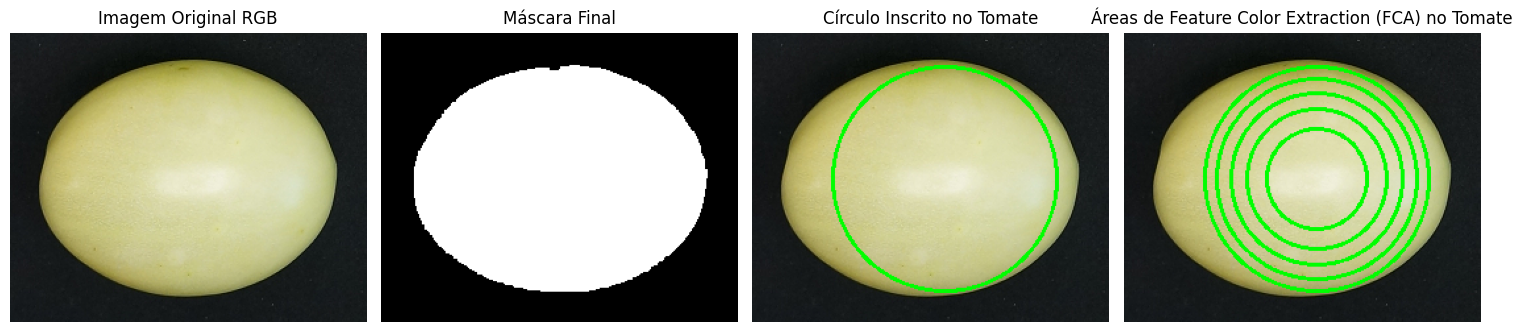

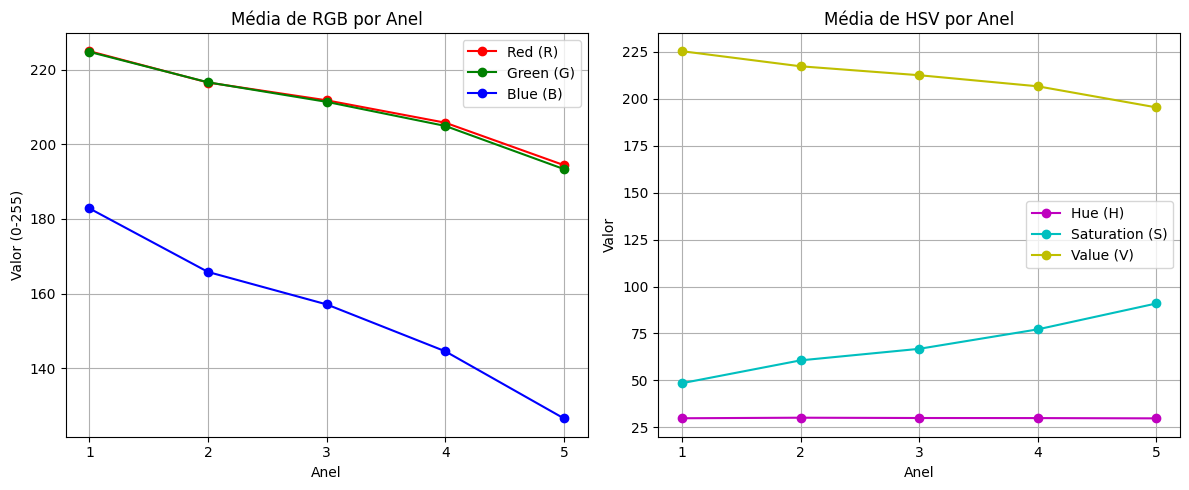

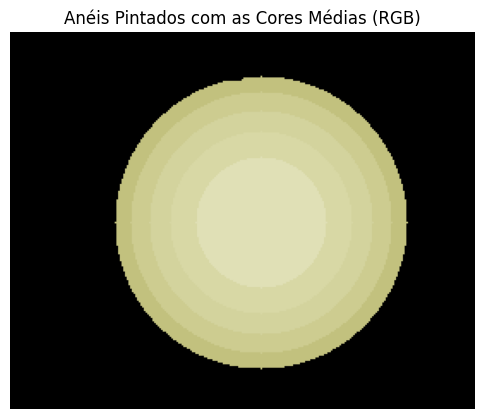

[[(224.95125193884334, 224.76179924662088, 182.81453578550853), (216.55167597765362, 216.60917132216014, 165.79306331471136), (211.78651433691755, 211.3774641577061, 157.1034946236559), (205.79307502061008, 204.9272464962902, 144.54225061830172), (194.4268506351292, 193.36881296539642, 126.57161629434954)], [(29.8014624418347, 48.48038998448925, 225.3871039220031), (30.0963687150838, 60.64781191806331, 217.34124767225325), (29.934363799283155, 66.79189068100358, 212.58848566308242), (29.893239901071723, 77.1636438582028, 206.68219291014015), (29.745072273324574, 90.96057818659658, 195.44831362242664)]]


In [52]:
print(calculate_tomato_fcas('./test_images/','7(orig_dataset).bmp', True, True, True))

Resultados para 7(orig_dataset).bmp:


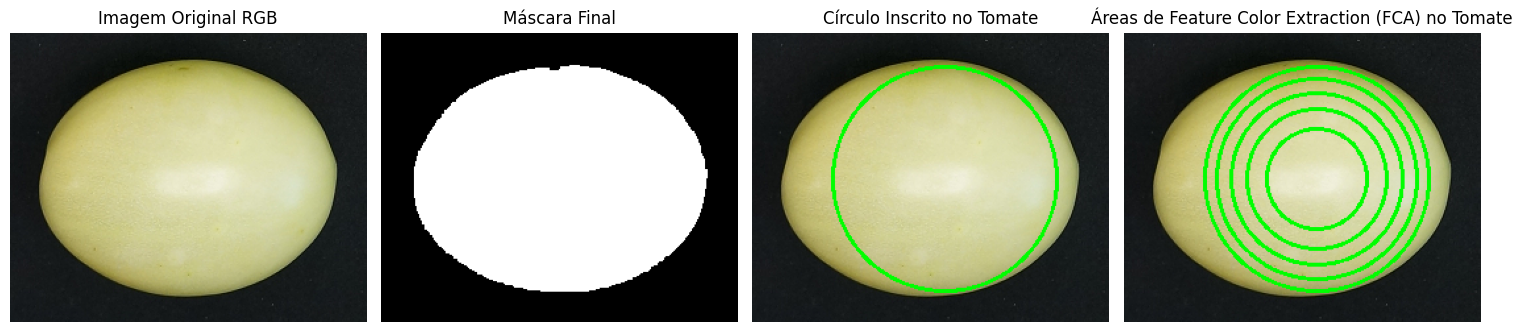

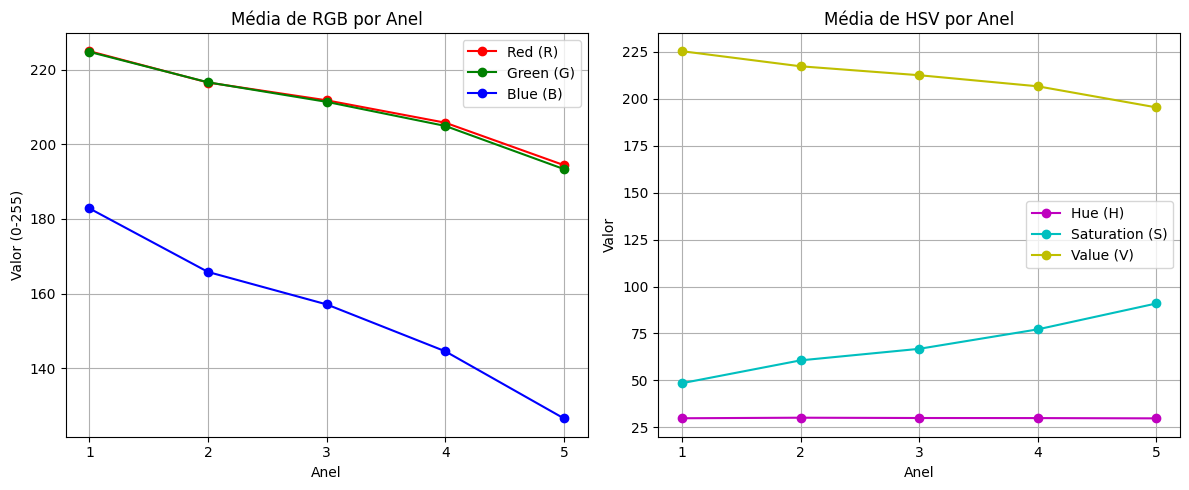

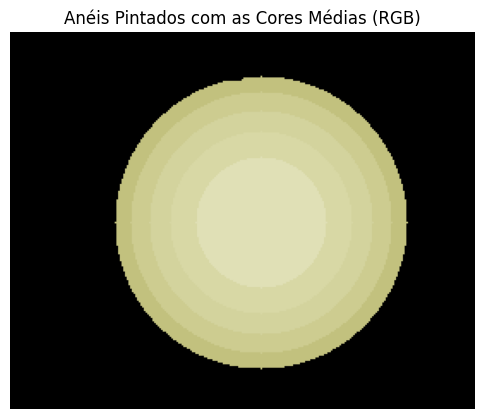

Resultados para 8(orig_dataset).bmp:


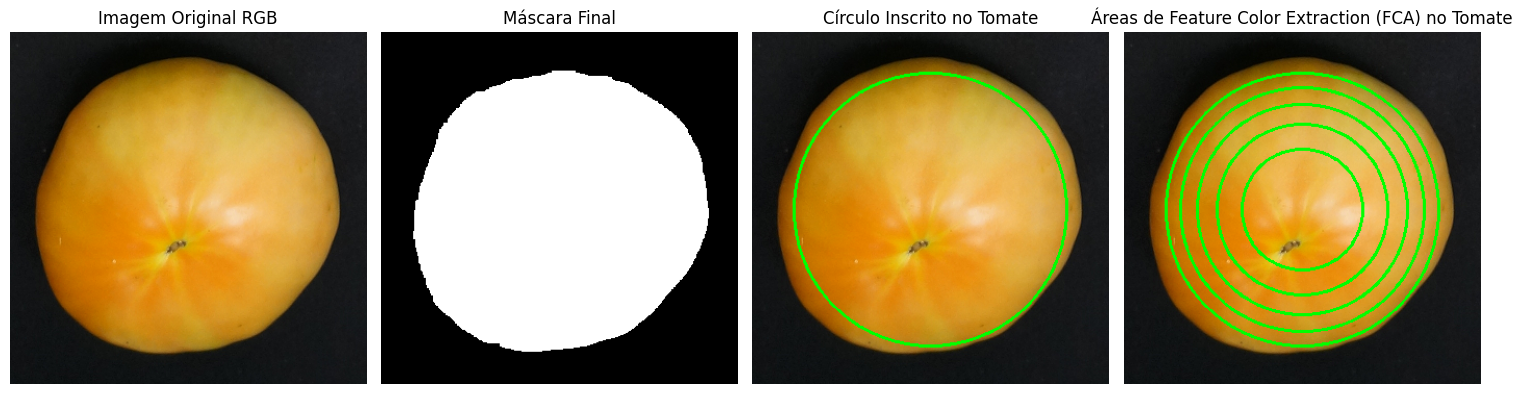

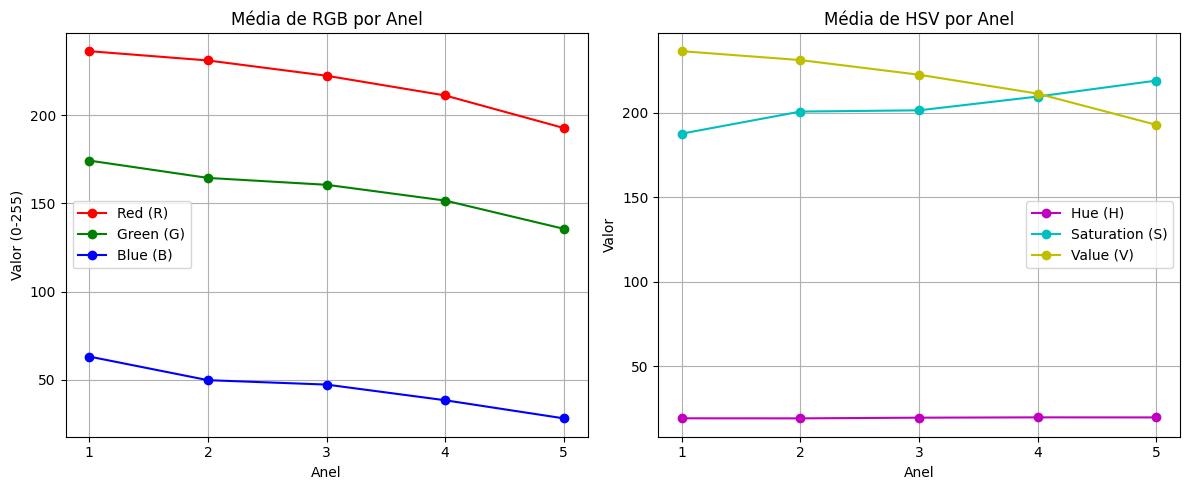

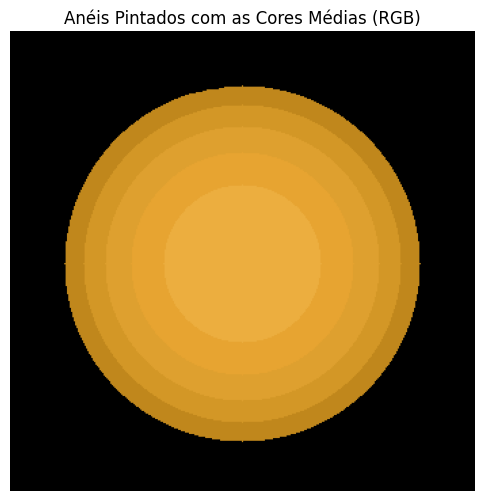

Resultados para 9(orig_dataset).bmp:


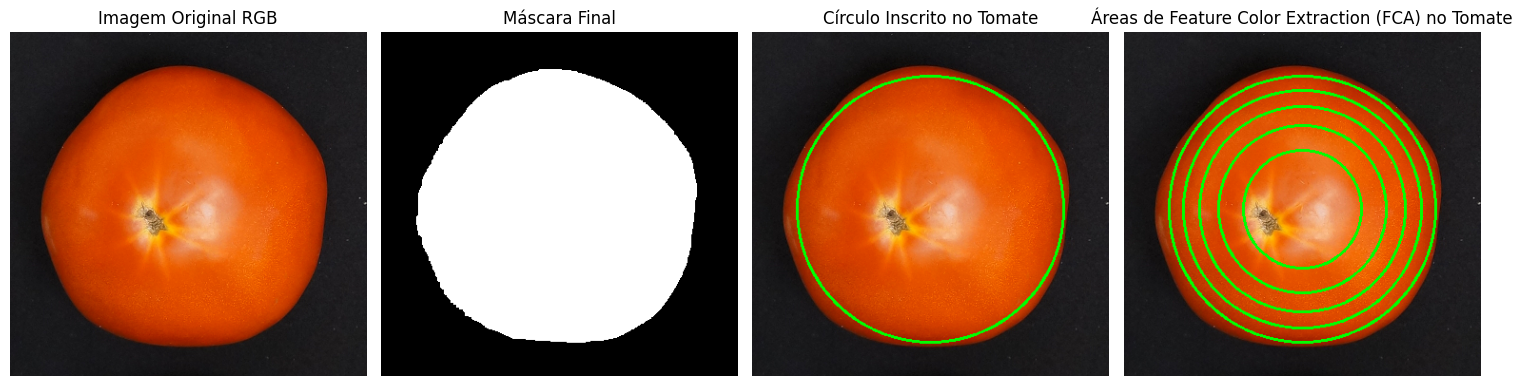

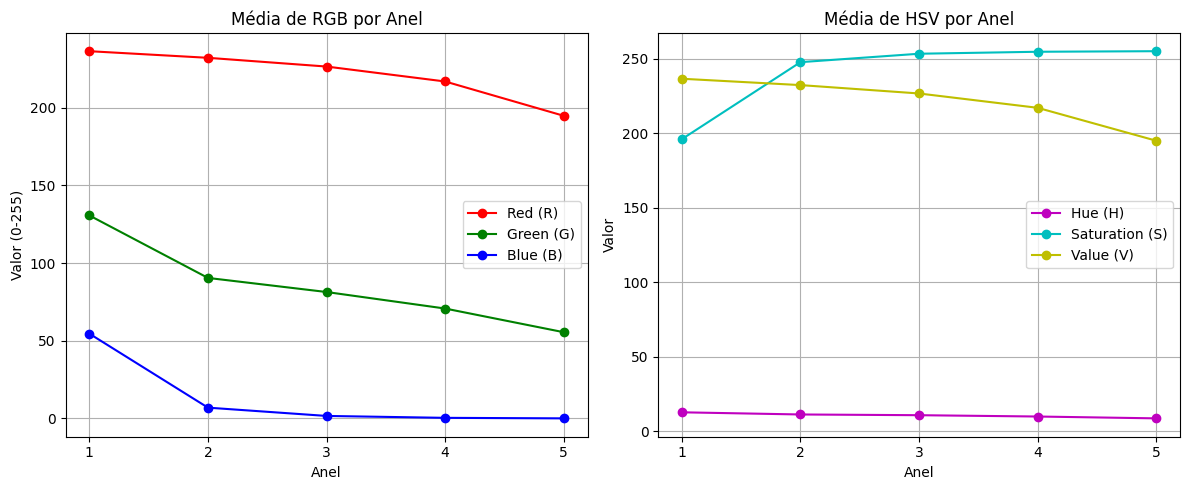

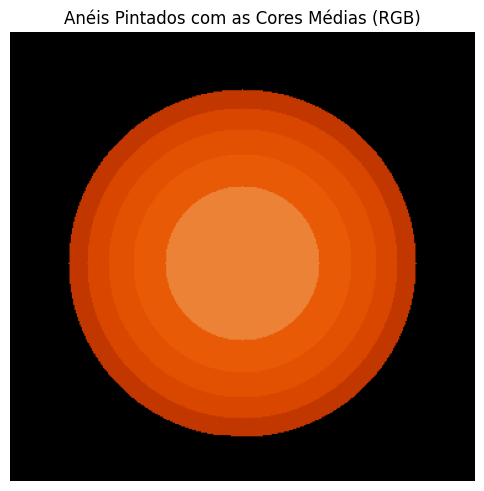

In [53]:
base_path = './test_images/'
for img_name in ['7(orig_dataset).bmp', '8(orig_dataset).bmp', '9(orig_dataset).bmp']:
    print(f"Resultados para {img_name}:")
    calculate_tomato_fcas(base_path, img_name, True, True, False)

In [54]:
def plot_comparative_rgb_hsv(red_rgb, orange_rgb, green_rgb, red_hsv, orange_hsv, green_hsv):
    fc_indexes = np.arange(1, 6)  # FCA 1 to 5
    width = 0.25  # Bar width

    # Extract components
    def extract_channels(color_list):
        return (
            [x[0] for x in color_list],  # R or H
            [x[1] for x in color_list],  # G or S
            [x[2] for x in color_list],  # B or V
        )

    # RGB
    red_r, red_g, red_b = extract_channels(red_rgb)
    orange_r, orange_g, orange_b = extract_channels(orange_rgb)
    green_r, green_g, green_b = extract_channels(green_rgb)

    # HSV
    red_h, red_s, red_v = extract_channels(red_hsv)
    orange_h, orange_s, orange_v = extract_channels(orange_hsv)
    green_h, green_s, green_v = extract_channels(green_hsv)

    # Create figure
    plt.figure(figsize=(14, 6))

    # RGB Plot
    plt.subplot(1,2,1)
    x = np.arange(5)

    # Red channel
    plt.bar(x - width, red_r, width, label='Red Tomato - R', color='darkred')
    plt.bar(x, orange_r, width, label='Orange Tomato - R', color='orangered')
    plt.bar(x + width, green_r, width, label='Green Tomato - R', color='seagreen')

    # Green and Blue channels (overlayed markers for clarity)
    plt.plot(fc_indexes, red_g, 'go--', label='Red Tomato - G')
    plt.plot(fc_indexes, orange_g, 'go:', label='Orange Tomato - G', alpha=0.6)
    plt.plot(fc_indexes, green_g, 'go-.', label='Green Tomato - G', alpha=0.6)

    plt.plot(fc_indexes, red_b, 'bo--', label='Red Tomato - B')
    plt.plot(fc_indexes, orange_b, 'bo:', label='Orange Tomato - B', alpha=0.6)
    plt.plot(fc_indexes, green_b, 'bo-.', label='Green Tomato - B', alpha=0.6)

    plt.title("Comparação RGB por Anel")
    plt.xlabel("FCA (Anel)")
    plt.ylabel("Valor (0-255)")
    plt.xticks(fc_indexes)
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True)

    # HSV Plot
    plt.subplot(1,2,2)

    # Hue bars
    plt.bar(x - width, red_h, width, label='Red Tomato - H', color='darkred')
    plt.bar(x, orange_h, width, label='Orange Tomato - H', color='orangered')
    plt.bar(x + width, green_h, width, label='Green Tomato - H', color='seagreen')

    # Saturation and Value (overlayed markers)
    plt.plot(fc_indexes, red_s, 'co--', label='Red Tomato - S')
    plt.plot(fc_indexes, orange_s, 'co:', label='Orange Tomato - S', alpha=0.6)
    plt.plot(fc_indexes, green_s, 'co-.', label='Green Tomato - S', alpha=0.6)

    plt.plot(fc_indexes, red_v, 'yo--', label='Red Tomato - V')
    plt.plot(fc_indexes, orange_v, 'yo:', label='Orange Tomato - V', alpha=0.6)
    plt.plot(fc_indexes, green_v, 'yo-.', label='Green Tomato - V', alpha=0.6)

    plt.title("Comparação HSV por Anel")
    plt.xlabel("FCA (Anel)")
    plt.ylabel("Valor")
    plt.xticks(fc_indexes)
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


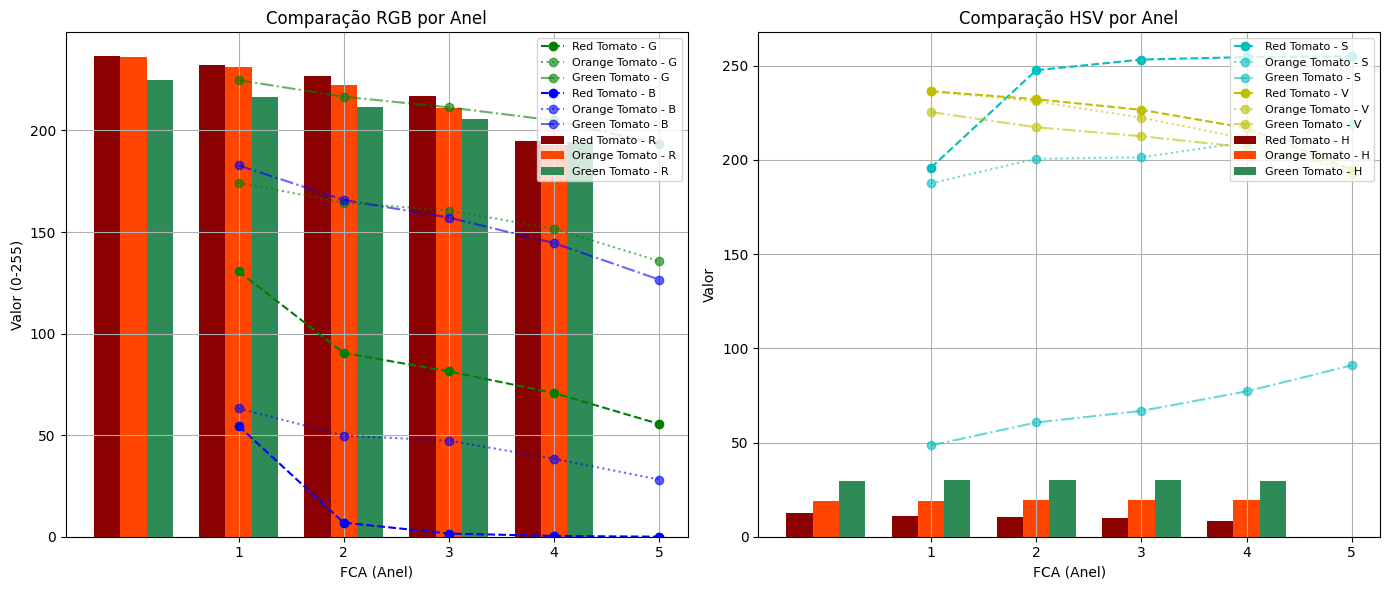

In [55]:
base_path = './test_images/'

green_rgb, green_hsv = calculate_tomato_fcas(base_path, '7(orig_dataset).bmp', False, False, False)
orange_rgb, orange_hsv = calculate_tomato_fcas(base_path, '8(orig_dataset).bmp', False, False, False)
red_rgb, red_hsv = calculate_tomato_fcas(base_path, '9(orig_dataset).bmp', False, False, False)

plot_comparative_rgb_hsv(red_rgb, orange_rgb, green_rgb, red_hsv, orange_hsv, green_hsv)

In [ ]:
import os

base_path = './test_images/'
# Full dataset path: './original_dataset/data/tomato samples (1)/'
# Test dataset path: './test_images/'

for img_name in os.listdir(base_path):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        print(f"Processando {img_name}...")
        calculate_tomato_fcas(base_path, img_name, show_results=False, plot_results=False, print_results=False, save_show_results=True)


Processando B-G-1.bmp...
Processando B-G-10.bmp...
Processando B-G-11.bmp...
Processando B-G-12.bmp...
Processando B-G-13.bmp...
Processando B-G-14.bmp...
Processando B-G-15.bmp...
Processando B-G-16.bmp...
Processando B-G-17.bmp...
Processando B-G-18.bmp...
Processando B-G-19.bmp...
Processando B-G-2.bmp...
Processando B-G-20.bmp...
Processando B-G-21.bmp...
Processando B-G-22.bmp...
Processando B-G-23.bmp...
Processando B-G-24.bmp...
Processando B-G-25.bmp...
Processando B-G-26.bmp...
Processando B-G-27.bmp...
Processando B-G-28.bmp...
Processando B-G-3.bmp...
Processando B-G-4.bmp...
Processando B-G-5.bmp...
Processando B-G-6.bmp...
Processando B-G-7.bmp...
Processando B-G-8.bmp...
Processando B-G-9.bmp...
Processando B-M-1.bmp...
Processando B-M-2.bmp...
Processando B-M-3.bmp...
Processando B-M-4.bmp...
Processando B-R-1.bmp...
Processando B-R-10.bmp...
Processando B-R-11.bmp...
Processando B-R-12.bmp...
Processando B-R-13.bmp...
Processando B-R-14.bmp...
Processando B-R-15.bmp...


In [10]:
import os
import csv

base_path = './test_images/'
output_csv = './test_fca.csv'
# Full dataset path: './original_dataset/data/tomato samples (1)/'
# Test dataset path: './test_images/'

dataset = []

for img_name in os.listdir(base_path):
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        parts = img_name.split('-')
        t_type = parts[0]
        t_class = parts[1]

        rgb_fcas, hsv_fcas = calculate_tomato_fcas(base_path, img_name, False, False, False, save_show_results=True)

        # Flatten RGB and HSV values: [R1, G1, B1, R2, G2, B2, ..., H5, S5, V5]
        rgb_flat = [round(c, 2) for fc in rgb_fcas for c in fc]
        hsv_flat = [round(c, 2) for fc in hsv_fcas for c in fc]

        row = [img_name, t_type, t_class] + rgb_flat + hsv_flat

        dataset.append(row)

# Create header
header = ['file_name', 'type', 'class']
for i in range(1, 6):
    header += [f'R{i}', f'G{i}', f'B{i}']
for i in range(1, 6):
    header += [f'H{i}', f'S{i}', f'V{i}']

os.makedirs('./results', exist_ok=True)

with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(dataset)

print(f'Dataset salvo em {output_csv}')


Dataset salvo em ./test_fca.csv
